## 1. Clip the satellite image (NDVI) with Rwanda shapefile

In [1]:
import fiona
from rasterio.mask import mask
import io 
import matplotlib
from matplotlib.pyplot import imread
import imageio
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
import geopandas as gpd

In [2]:
ndvi_rwd = rio.open('/Users/elisaxchen/Downloads/MOD13A1.006__500m_16_days_NDVI_doy2010001_aid0001.tif')

In [3]:
with rio.open('/Users/elisaxchen/Downloads/MOD13A1.006__500m_16_days_NDVI_doy2010001_aid0001.tif') as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -3000.0, 'width': 543, 'height': 455, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(463.312716527778, 0.0, 3187591.4897111123,
       0.0, -463.312716527778, -109341.8011005556), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


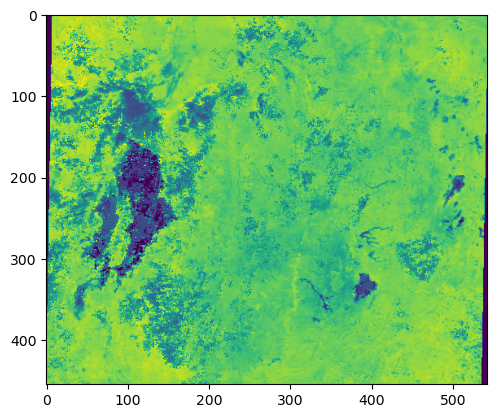

<AxesSubplot:>

In [4]:
fp = r'/Users/elisaxchen/Downloads/MOD13A1.006__500m_16_days_NDVI_doy2010001_aid0001.tif'
img = rio.open(fp) 
# mention band no. in read() method starting from 1 not 0
show(img.read())

In [6]:
with fiona.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project//raw_data/shapefiles/Sector_Boundary_2012.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [5]:
shp = gpd.read_file('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project//raw_data/shapefiles/Sector_Boundary_2012.shp')

In [6]:
shp

,Prov_ID,Province,Dist_ID,District,Sect_ID,Sector,geometry
0,1.0,Kigali City,11.0,Nyarugenge,1101.0,Gitega,"POLYGON ((30.04829 -1.94176, 30.04833 -1.94178..."
1,1.0,Kigali City,11.0,Nyarugenge,1102.0,Kanyinya,"POLYGON ((29.98964 -1.86756, 29.98957 -1.86789..."
2,1.0,Kigali City,11.0,Nyarugenge,1103.0,Kigali,"POLYGON ((30.04030 -1.94181, 30.04036 -1.94183..."
3,1.0,Kigali City,11.0,Nyarugenge,1104.0,Kimisagara,"POLYGON ((30.04496 -1.93947, 30.04501 -1.93955..."
4,1.0,Kigali City,11.0,Nyarugenge,1105.0,Mageregere,"POLYGON ((30.05227 -2.00171, 30.05232 -2.00175..."
...,...,...,...,...,...,...,...
411,5.0,Eastern Province,57.0,Bugesera,5711.0,Nyarugenge,"POLYGON ((30.02756 -2.26839, 30.02810 -2.26985..."
412,5.0,Eastern Province,57.0,Bugesera,5712.0,Rilima,"POLYGON ((30.17277 -2.11490, 30.17365 -2.11542..."
413,5.0,Eastern Province,57.0,Bugesera,5713.0,Ruhuha,"POLYGON ((30.09253 -2.28683, 30.09287 -2.28766..."
414,5.0,Eastern Province,57.0,Bugesera,5714.0,Rweru,"POLYGON ((30.32350 -2.19875, 30.32362 -2.19909..."


In [14]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', shp.crs)
print('Imagery file Projection: ', img.crs)

Shape file Projection:  epsg:4326
Imagery file Projection:  PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [9]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [11]:
# Transform projection of imagery to specific coordinate system
# cite: https://thinkinfi.com/clip-raster-with-a-shape-file-in-python/

# Specify output projection system
dst_crs = 'EPSG:4326'

# Input imagery file name before transformation
input_imagery_file = '/Users/elisaxchen/Downloads/MOD13A1.006__500m_16_days_NDVI_doy2010001_aid0001.tif'
# Save output imagery file name after transformation
transformed_imagery_file = 'ndvi.tif'

with rio.open(input_imagery_file) as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
    with rio.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rio.band(imagery, i),
                destination=rio.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

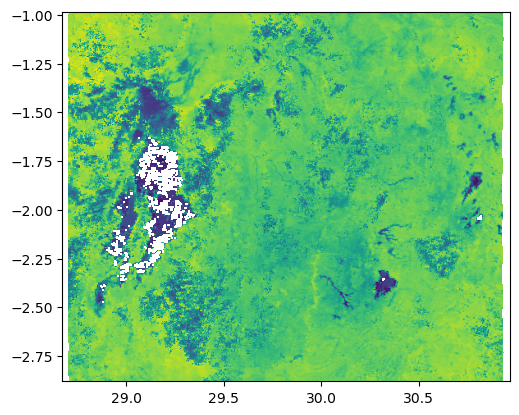

Transformed Imagery file Projection:  EPSG:4326


In [13]:
# Plot again after transformation. You can observe axis value have changed
tr_imagery = rio.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/ndvi.tif')
# Plot trasformed imagery
show(tr_imagery)

# Check coordinate reference system of transformed imagery - yes, we got 4326
print('Transformed Imagery file Projection: ', tr_imagery.crs)
# tr_imagery.crs

In [17]:
# Read Shape file
with fiona.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project//raw_data/shapefiles/Sector_Boundary_2012.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# read imagery file
with rio.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/ndvi.tif') as src:
    out_image, out_transform = rio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

# Save clipped imagery
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/ndvi.tif', "w", **out_meta) as dest:
    dest.write(out_image)

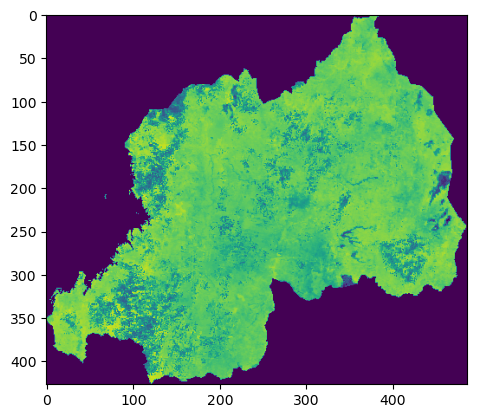

<AxesSubplot:>

In [22]:
# Open the clipped raster file 
ndvi_rd = rio.open('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/ndvi.tif')
show(ndvi_rd.read())

## 2. Get NDVI for Each Village

In [1]:
import dask
from dask.distributed import Client, progress
from dask import delayed
import rioxarray 
import geopandas as gpd

In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:59127 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GiB


In [30]:
# cite: https://github.com/MengChenC/NDVI-and-Human-Well-being/blob/main/Jupyter%20Notebooks/Gather_Yearly_Vegetation_with_Dask.ipynb
@dask.delayed
def get_avg_ndvi(tif_file, shape_file, cluster_idx): 
    with rioxarray.open_rasterio(tif_file) as xds: 
        if shape_file.geometry[cluster_idx] != 'MultiPolygon':
            clipped = xds.rio.clip([shape_file.geometry[cluster_idx]])
        else:
            clipped = xds.rio.clip([shape_file.geometry[cluster_idx]])
        clipped = clipped.squeeze().stack(z=('x','y'))
        clipped = clipped.mean()
    return clipped

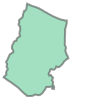

In [31]:
shape_file.geometry[415]

In [32]:
shape_file = shp 
cluster_idx_list = [i for i in range (416)]
ndvi_file = ['/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/ndvi.tif']

In [33]:
ndvi_dic = {} 
for cluster_idx in cluster_idx_list:
    clipped = get_avg_ndvi(tif_file, shape_file, cluster_idx)
    if i == 0: 
        ndvi_dic[cluster_idx] = clipped 
    else: 
        ndvi_dic[cluster_idx] += clipped 
ndvi_dic

{0: Delayed('get_avg_ndvi-564f1190-b812-49a0-b040-554b3aeb53ea'),
 1: Delayed('get_avg_ndvi-1e9fe632-2ede-471e-8e1f-8fa54bc5108b'),
 2: Delayed('get_avg_ndvi-0fe01461-9b1c-4821-9fe7-cc2af0ee7973'),
 3: Delayed('get_avg_ndvi-d79d5bb3-9520-4431-971d-731168721248'),
 4: Delayed('get_avg_ndvi-dc296a39-3fb6-404e-ae99-93ff5b70eb87'),
 5: Delayed('get_avg_ndvi-ba70f4f0-4d95-43f5-bca3-5163c1cba7d2'),
 6: Delayed('get_avg_ndvi-499ef386-b473-404d-8c85-a6a6ef88ea20'),
 7: Delayed('get_avg_ndvi-3d029aeb-41a9-4bcf-93b6-1d5688ff758b'),
 8: Delayed('get_avg_ndvi-91b154c8-6076-4534-94e0-2f832bf9f953'),
 9: Delayed('get_avg_ndvi-07c63b5b-7bd8-4220-9844-dfbf0a47598e'),
 10: Delayed('get_avg_ndvi-311eb312-363f-4ca6-b302-8c9995c5ee35'),
 11: Delayed('get_avg_ndvi-2beb92bf-58de-45cd-b15d-fa18106f48b2'),
 12: Delayed('get_avg_ndvi-b869ed1d-7eeb-4781-b45d-2170f7fc16b4'),
 13: Delayed('get_avg_ndvi-21eb8df6-9529-4e9f-a4f3-eb26f350e0cd'),
 14: Delayed('get_avg_ndvi-87ac0d9e-ca84-49bb-a168-9d960d511550'),
 15: 

In [34]:
ndvi_dic = {k: v.compute() for k, v in ndvi_dic.items()}
ndvi_dic

/Users/elisaxchen/opt/anaconda3/lib/python3.8/site-packages/distributed/worker.py:3560: UserWarning: Large object of size 9.00 MiB detected in task graph: 
  ('/Users/elisaxchen/UChicago/Spring 2022 Courses/L ...  7 columns], 0)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


{0: <xarray.DataArray ()>
 array(407.8)
 Coordinates:
     band         int64 1
     spatial_ref  int64 0,
 1: <xarray.DataArray ()>
 array(1046.31153846)
 Coordinates:
     band         int64 1
     spatial_ref  int64 0,
 2: <xarray.DataArray ()>
 array(3466.95454545)
 Coordinates:
     band         int64 1
     spatial_ref  int64 0,
 3: <xarray.DataArray ()>
 array(1779.16666667)
 Coordinates:
     band         int64 1
     spatial_ref  int64 0,
 4: <xarray.DataArray ()>
 array(2500.63333333)
 Coordinates:
     band         int64 1
     spatial_ref  int64 0,
 5: <xarray.DataArray ()>
 array(437.39285714)
 Coordinates:
     band         int64 1
     spatial_ref  int64 0,
 6: <xarray.DataArray ()>
 array(1856.9375)
 Coordinates:
     band         int64 1
     spatial_ref  int64 0,
 7: <xarray.DataArray ()>
 array(1195.07142857)
 Coordinates:
     band         int64 1
     spatial_ref  int64 0,
 8: <xarray.DataArray ()>
 array(1742.2)
 Coordinates:
     band         int64 1
     spatial

In [25]:
# save the index
import pickle 
with open('ndvi.pickle','wb') as outputfile: 
    pickle.dump(ndvi_dic, outputfile)

with open('ndvi.pickle','rb') as inputfile: 
    print(pickle.load(inputfile))

{0: <xarray.DataArray ()>
array(407.8)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 1: <xarray.DataArray ()>
array(1046.31153846)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 2: <xarray.DataArray ()>
array(3466.95454545)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 3: <xarray.DataArray ()>
array(1779.16666667)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 4: <xarray.DataArray ()>
array(2500.63333333)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 5: <xarray.DataArray ()>
array(437.39285714)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 6: <xarray.DataArray ()>
array(1856.9375)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 7: <xarray.DataArray ()>
array(1195.07142857)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 8: <xarray.DataArray ()>
array(1742.2)
Coordinates:
    band         int64 1
    spatial_ref  int64 0, 9: <xarray.DataArray ()>
arra

In [82]:
# convert index dic to list 
ndvi_list = [i[1].values.item(0) for i in list(ndvi_dic.items())]
ndvi_list

[407.8,
 1046.3115384615385,
 3466.9545454545455,
 1779.1666666666667,
 2500.633333333333,
 437.39285714285717,
 1856.9375,
 1195.0714285714287,
 1742.2,
 -301.9166666666667,
 946.8047619047619,
 3471.7555555555555,
 3265.9444444444443,
 4304.619047619048,
 2248.3552631578946,
 1349.404761904762,
 951.0,
 2953.3333333333335,
 2873.25,
 2426.6844919786095,
 1192.1145454545454,
 2996.3625730994154,
 67.0125,
 2005.3243801652893,
 691.5258799171843,
 2787.018382352941,
 425.48571428571427,
 659.1875,
 1691.4,
 1617.3333333333333,
 1919.125,
 1132.4155844155844,
 2980.7161125319694,
 1182.35,
 895.2969696969697,
 1875.5690476190475,
 3055.655303030303,
 2512.895652173913,
 1963.0636604774536,
 1289.7492063492064,
 2835.806818181818,
 3253.3375,
 1377.6339869281046,
 1302.5710344827587,
 2194.9545454545455,
 1560.3865546218487,
 2322.7969348659003,
 1772.3368421052633,
 2355.656346749226,
 1746.2272727272727,
 1648.7837837837837,
 2260.546822742475,
 1893.2763157894738,
 1519.3118908382066,

In [94]:
# normalize NDVI to (-1,1)
import numpy as np
from sklearn import preprocessing
list = list = np.array(ndvi_list).reshape(-1,1)
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
ndvi =scaler.fit_transform(list)
print('Normalized List:', ndvi)

Normalized List: [[-0.42804453]
 [-0.23199385]
 [ 0.51124835]
 [-0.00697559]
 [ 0.21454591]
 [-0.41895824]
 [ 0.01690342]
 [-0.18631812]
 [-0.01832596]
 [-0.64595827]
 [-0.26254673]
 [ 0.51272247]
 [ 0.44952955]
 [ 0.76844762]
 [ 0.13708562]
 [-0.1389311 ]
 [-0.26125861]
 [ 0.3535444 ]
 [ 0.32895535]
 [ 0.19184041]
 [-0.18722601]
 [ 0.36675624]
 [-0.53268105]
 [ 0.06246461]
 [-0.3409284 ]
 [ 0.30247851]
 [-0.42261425]
 [-0.35085769]
 [-0.03392376]
 [-0.05666543]
 [ 0.03599767]
 [-0.20555618]
 [ 0.3619521 ]
 [-0.19022415]
 [-0.27836186]
 [ 0.02262411]
 [ 0.38496168]
 [ 0.21831097]
 [ 0.04948874]
 [-0.15724794]
 [ 0.31745868]
 [ 0.44565867]
 [-0.13026351]
 [-0.15331109]
 [ 0.12068928]
 [-0.07415056]
 [ 0.15994243]
 [-0.00907265]
 [ 0.17003169]
 [-0.01708941]
 [-0.04700878]
 [ 0.14082895]
 [ 0.02806101]
 [-0.08676226]
 [ 0.17625094]
 [-0.09841104]
 [ 0.35598796]
 [ 0.04496159]
 [ 0.20410066]
 [ 0.128186  ]
 [ 0.04749798]
 [ 0.09172416]
 [-0.14871987]
 [-0.00861935]
 [ 0.17907814]
 [ 0.342

## 3. Merge NDVI List With Village Wealth

In [83]:
import pandas as pd 
cluster_wealth = pd.read_csv('/Users/elisaxchen/UChicago/Spring 2022 Courses/Large Scale Computing/HW/Final Project/cluster_wealth.csv',
                            index_col = 0)

In [95]:
shape_file['ndvi'] = ndvi
shape_file

,Prov_ID,Province,Dist_ID,District,Sect_ID,Sector,geometry,ndvi
0,1.0,Kigali City,11.0,Nyarugenge,1101.0,Gitega,"POLYGON ((30.04829 -1.94176, 30.04833 -1.94178...",-0.428045
1,1.0,Kigali City,11.0,Nyarugenge,1102.0,Kanyinya,"POLYGON ((29.98964 -1.86756, 29.98957 -1.86789...",-0.231994
2,1.0,Kigali City,11.0,Nyarugenge,1103.0,Kigali,"POLYGON ((30.04030 -1.94181, 30.04036 -1.94183...",0.511248
3,1.0,Kigali City,11.0,Nyarugenge,1104.0,Kimisagara,"POLYGON ((30.04496 -1.93947, 30.04501 -1.93955...",-0.006976
4,1.0,Kigali City,11.0,Nyarugenge,1105.0,Mageregere,"POLYGON ((30.05227 -2.00171, 30.05232 -2.00175...",0.214546
...,...,...,...,...,...,...,...,...
411,5.0,Eastern Province,57.0,Bugesera,5711.0,Nyarugenge,"POLYGON ((30.02756 -2.26839, 30.02810 -2.26985...",0.188311
412,5.0,Eastern Province,57.0,Bugesera,5712.0,Rilima,"POLYGON ((30.17277 -2.11490, 30.17365 -2.11542...",-0.217979
413,5.0,Eastern Province,57.0,Bugesera,5713.0,Ruhuha,"POLYGON ((30.09253 -2.28683, 30.09287 -2.28766...",0.175353
414,5.0,Eastern Province,57.0,Bugesera,5714.0,Rweru,"POLYGON ((30.32350 -2.19875, 30.32362 -2.19909...",-0.342642


In [96]:
cluster_wealth

,cluster,wealth,DHSCLUST,LATNUM,LONGNUM,Point,Sect_ID
0,1,-0.386620,1.0,-2.532818,29.684726,POINT (29.684726 -2.532818),2407.0
1,2,-0.421574,2.0,-1.833858,30.310689,POINT (30.310689 -1.833858),5301.0
2,3,-0.449724,3.0,-1.888155,29.478298,POINT (29.478298 -1.888155),3513.0
3,4,-0.390006,4.0,-2.366763,30.521692,POINT (30.521692 -2.366763),5501.0
4,5,-0.416924,5.0,-2.171266,30.018541,POINT (30.018541 -2.171266),5706.0
...,...,...,...,...,...,...,...
487,488,-0.490285,488.0,-2.389778,29.451722,POINT (29.451722 -2.389778),2513.0
488,489,-0.387647,489.0,-2.144317,30.348895,POINT (30.348895 -2.144317),5606.0
489,490,0.451675,490.0,-1.967830,30.441541,POINT (30.441541 -1.96783),5105.0
490,491,-0.217502,491.0,-1.441294,30.063765,POINT (30.063765 -1.441294),4507.0


In [86]:
from shapely.geometry import Point, Polygon

In [97]:
def find_sect(point, poly_list, sect_id_list):
    for i in range(len(poly_list)):
        if point.within(poly_list[i]):
            return sect_id_list[i]
    return None

In [98]:

cluster_wealth['Point'] = cluster_wealth.apply(lambda row: Point(row['LONGNUM'],row['LATNUM']), axis=1)
cluster_wealth['Sect_ID'] = cluster_wealth['Point'].apply(lambda x: find_sect(x, shape_file['geometry'].tolist(), shape_file['Sect_ID'].tolist()))
df = cluster_wealth.merge(shape_file, on='Sect_ID')
df


,cluster,wealth,DHSCLUST,LATNUM,LONGNUM,Point,Sect_ID,Prov_ID,Province,Dist_ID,District,Sector,geometry,ndvi
0,1,-0.386620,1.0,-2.532818,29.684726,POINT (29.684726 -2.532818),2407.0,2.0,Southern Province,24.0,Huye,Mbazi,"POLYGON ((29.72323 -2.51188, 29.72331 -2.51191...",-0.204048
1,105,-0.483911,105.0,-2.576043,29.741134,POINT (29.741134 -2.576043),2407.0,2.0,Southern Province,24.0,Huye,Mbazi,"POLYGON ((29.72323 -2.51188, 29.72331 -2.51191...",-0.204048
2,2,-0.421574,2.0,-1.833858,30.310689,POINT (30.310689 -1.833858),5301.0,5.0,Eastern Province,53.0,Gatsibo,Gasange,"POLYGON ((30.26891 -1.75314, 30.26911 -1.75376...",-0.485647
3,3,-0.449724,3.0,-1.888155,29.478298,POINT (29.478298 -1.888155),3513.0,3.0,Western Province,35.0,Ngororero,Sovu,"POLYGON ((29.47525 -1.88013, 29.47546 -1.88026...",0.109262
4,14,-0.379098,14.0,-1.912341,29.512758,POINT (29.512758 -1.912341),3513.0,3.0,Western Province,35.0,Ngororero,Sovu,"POLYGON ((29.47525 -1.88013, 29.47546 -1.88026...",0.109262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,485,-0.245533,485.0,-2.343529,30.699000,POINT (30.699 -2.343529),5503.0,5.0,Eastern Province,55.0,Kirehe,Kigarama,"POLYGON ((30.72631 -2.28707, 30.72652 -2.28737...",0.044021
487,486,-0.141368,486.0,-2.336048,30.288211,POINT (30.288211 -2.336048),5714.0,5.0,Eastern Province,57.0,Bugesera,Rweru,"POLYGON ((30.32350 -2.19875, 30.32362 -2.19909...",-0.342642
488,488,-0.490285,488.0,-2.389778,29.451722,POINT (29.451722 -2.389778),2513.0,2.0,Southern Province,25.0,Nyamagabe,Musebeya,"POLYGON ((29.46254 -2.34009, 29.46268 -2.34010...",-0.079151
489,489,-0.387647,489.0,-2.144317,30.348895,POINT (30.348895 -2.144317),5606.0,5.0,Eastern Province,56.0,Ngoma,Mugesera,"POLYGON ((30.37719 -2.07838, 30.37771 -2.07839...",0.167950


Text(0, 0.5, 'Average Village Wealth')

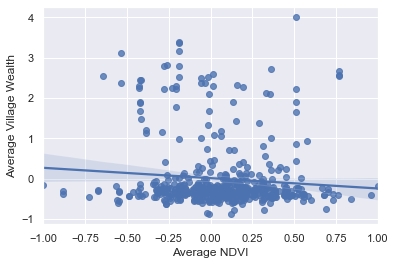

In [100]:
# plot the relationship between ndvi and village wealth 
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)
sns.regplot(x="ndvi", y="wealth", data=df)
plt.xlabel('Average NDVI')
plt.ylabel('Average Village Wealth')

In [101]:
import statsmodels.api as sm 

x = df['ndvi']
y = df['wealth']
model = sm.OLS(y,x)
reg = model.fit()
print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                 wealth   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              4.026
Date:                Sun, 29 May 2022   Prob (F-statistic):                      0.0453
Time:                        22:32:15   Log-Likelihood:                         -604.35
No. Observations:                 491   AIC:                                      1211.
Df Residuals:                     490   BIC:                                      1215.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------